In [1]:
import os
!pip -q install langchain-core langchain-community langgraph langchain-openai duckduckgo-search

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.7/409.7 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.8 MB/s eta 0:00:00


## LangGraph ReAct Function Calling Pattern

- Search

- Math

---



## Traditional ReAct Prompt

In [29]:
react_prompt = """Assistant is a large language model trained by Microsoft.

Assistant is designed to be able to assist with a wide range of tasks, from answering simple questions to providing in-depth explanations and discussions on a wide range of topics. As a language model, Assistant is able to generate human-like text based on the input it receives, allowing it to engage in natural-sounding conversations and provide responses that are coherent and relevant to the topic at hand.

Assistant is constantly learning and improving, and its capabilities are constantly evolving. It is able to process and understand large amounts of text, and can use this knowledge to provide accurate and informative responses to a wide range of questions. Additionally, Assistant is able to generate its own text based on the input it receives, allowing it to engage in discussions and provide explanations and descriptions on a wide range of topics.

Overall, Assistant is a powerful tool that can help with a wide range of tasks and provide valuable insights and information on a wide range of topics. Whether you need help with a specific question or just want to have a conversation about a particular topic, Assistant is here to assist.

TOOLS:
------

Assistant has access to the following tools:

wikipedia_search - searches the wikipedia database for the answer\n
web_search - searches the web for the answer\n
calculator - calculates the answer to the question\n
weather_api - gets the weather for the location\n


To use a tool, please use the following format:

```
Thought: Do I need to use a tool? Yes
Action: the action to take, should be one of [wikipedia_search, web_search, calculator, weather_api]
Action Input: the input to the action
Observation: the result of the action
```

When you have a response to say to the Human, or if you do not need to use a tool, you MUST use the format:

```
Thought: Do I need to use a tool? No
Final Answer: [your response here]
```

Begin!


New input: Whow was King Arthur?
"""

In [1]:
from langchain_openai import ChatOpenAI
import dotenv
dotenv.load_dotenv()

llm = ChatOpenAI(model="gpt-4o")

### Tools

In [2]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

In [3]:
# search tools
from langchain_community.tools import DuckDuckGoSearchRun

search = DuckDuckGoSearchRun()

search.invoke("How old is Brad Pitt?")

'Brad Pitt is "missing" his children this holiday season, a source exclusively tells Page Six. ... 23, Pax, 21, Zahara, 19, Shiloh, 18, and 16-year-old twins Knox and Vivienne. Brad Pitt was born William Bradley Pitt on December 18, 1963, in Shawnee, Oklahoma. The eldest of three children in a devoutly Southern Baptist family, Brad grew up in Springfield, Missouri, with his siblings Doug and Julie. Brad Pitt marked his 60th birthday with a celebration at Mother Wolf in Los Angeles this week. One onlooker says the actor \'looked super happy\' at the party, and \'everyone had a smile on their faces.\' At the time of filming in early 2023, Brad Pitt was 59 years old, having been born on December 18, 1963. Wolfs began production in late 2021, but it wasn\'t until early 2023 that the film started filming scenes in New York City, just a month after his birthday. Angelina Jolie Gave An Update On Her 18-Year-Old Daughter Shiloh After She Dropped Brad Pitt\'s Last Name. Angelina shares her six 

In [4]:
tools = [add, multiply, divide, search]

llm_with_tools = llm.bind_tools(tools)

In [5]:
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs.")



## Nodes

In [6]:
from langgraph.graph import MessagesState
# Node
def reasoner(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}


### Building the graph

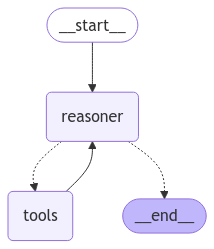

In [7]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition # this is the checker for if you got a tool back
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("reasoner", reasoner)
builder.add_node("tools", ToolNode(tools)) # for the tools

# Add edges
builder.add_edge(START, "reasoner")
builder.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "reasoner")
react_graph = builder.compile()

# Display the graph
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [8]:
messages = [HumanMessage(content="What is 2 times Brad Pitt's age?")]
messages = react_graph.invoke({"messages": messages})

In [9]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 times Brad Pitt's age?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_AyyDj7P2iXMuTqjkXtmRlCgX)
 Call ID: call_AyyDj7P2iXMuTqjkXtmRlCgX
  Args:
    query: Brad Pitt age 2023
================================= Tool Message =================================
Name: duckduckgo_search

Error: RatelimitException('https://links.duckduckgo.com/d.js?q=Brad+Pitt+age+2023&kl=wt-wt&l=wt-wt&p=&s=0&df=y&vqd=4-144682033816082074760523804194880172033&bing_market=wt-WT&ex=-1 202 Ratelimit')
 Please fix your mistakes.
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_17NMAu3fPdqrMOKDfHDNyAvN)
 Call ID: call_17NMAu3fPdqrMOKDfHDNyAvN
  Args:
    query: Brad Pitt age
================================= Tool Message =================================
Name: duckduckgo_search

Error: R

## More manual way and adding a custom tool

In [10]:
!pip -q install yfinance

In [18]:
import yfinance as yf

def get_stock_price(ticker: str) -> float:
    """Gets a stock price (previous close) from Yahoo Finance.

    Args:
        ticker: ticker str
    """
    # """This is a tool for getting the price of a stock when passed a ticker symbol"""
    stock = yf.Ticker(ticker)
    return stock.info['previousClose']

In [15]:
get_stock_price("TSLA")

369.49

In [ ]:
# from langchain_community.tools.yahoo_finance_news import YahooFinanceNewsTool

# y_finance = YahooFinanceNewsTool()

# y_finance.invoke("AAPL")

In [20]:
tools = [add, multiply, divide, search, get_stock_price]

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

In [27]:
tools[4]

<function __main__.get_stock_price(ticker: str) -> float>

In [28]:
from typing import Annotated, TypedDict
import operator
from langchain_core.messages import AnyMessage


class GraphState(TypedDict):
    """State of the graph."""
    query: str
    finance: str
    final_answer: str
    messages: Annotated[list[AnyMessage], operator.add]


In [19]:
# Node
def reasoner(state):
    query = state["query"]
    messages = state["messages"]
    # System message
    sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search, the yahoo finance tool and performing arithmetic on a set of inputs.")
    message = HumanMessage(content=query)
    messages.append(message)
    result = [llm_with_tools.invoke([sys_msg] + messages)]
    return {"messages":result}


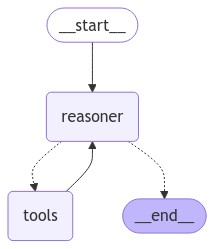

In [ ]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition # this is the checker for the
from langgraph.prebuilt import ToolNode


# Graph
workflow = StateGraph(GraphState)

# Add Nodes
workflow.add_node("reasoner", reasoner)
workflow.add_node("tools", ToolNode(tools)) # for the tools

# Add Edges
workflow.add_edge(START, "reasoner")

workflow.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)
workflow.add_edge("tools", "reasoner")
react_graph = workflow.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
response = react_graph.invoke({"query": "What is the stock price of the company that Jensen Huang is CEO of?", "messages": []})

In [ ]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the stock price of the company that Jensen Huang is CEO of?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_Lx0D1F4vLFCKEPWAVKWn3Dbr)
 Call ID: call_Lx0D1F4vLFCKEPWAVKWn3Dbr
  Args:
    query: Jensen Huang CEO company
================================= Tool Message =================================
Name: duckduckgo_search

Jensen Huang: from Denny's dishwasher to CEO of Nvidia | 60 Minutes 13:23. Only four companies in the world are worth more than $2 trillion: Microsoft, Apple, Alphabet — parent company of Google ... Nvidia CEO Jensen Huang launched his company in a booth at Denny's with his friends. Meet his cofounder who donated shares now worth $70 billion and moved off the grid ... Jensen Huang, Chris ... Nvidia CEO Jensen Huang delivers his keynote speech ahead of Computex 2024 in Taipei on June 2, 2024. When Nvidia surpas

In [ ]:
response = react_graph.invoke({"query": "What will be the price of nvidia stock if it doubles?", "messages": []})

In [ ]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What will be the price of nvidia stock if it doubles?
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (call_8iPPMM261Ddgr4LdAlhQ4wW9)
 Call ID: call_8iPPMM261Ddgr4LdAlhQ4wW9
  Args:
    ticker: NVDA
================================= Tool Message =================================
Name: get_stock_price

119.1
================================ Human Message =================================

What will be the price of nvidia stock if it doubles?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_uiTbfZ1pyR4TGayOPHXT1vZB)
 Call ID: call_uiTbfZ1pyR4TGayOPHXT1vZB
  Args:
    a: 11910
    b: 2
================================= Tool Message =================================
Name: multiply

23820
================================ Human Message =================================

What will be the pr

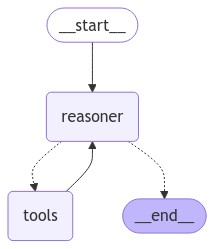

In [ ]:
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))